In [ ]:
#| default_exp core

## Preliminaries

In [ ]:
#| export
from scipy.integrate import odeint,ode
from pylab import *
from numpy import *
import pylab
from copy import deepcopy 

from matplotlib import rc
size=20
family='sans-serif'

rc('font',size=size,family=family)
rc('axes',titlesize=size,grid=True,labelsize=size)
rc('xtick',labelsize=size)
rc('ytick',labelsize=size)
rc('legend',fontsize=size)
rc('lines',linewidth=2)
rc('figure',figsize=(12,8))


import os
import sys

In [ ]:
#| export
import functools
from types import FunctionType

def copy_func(f):
    "Copy a non-builtin function (NB `copy.copy` does not work for this)"
    if not isinstance(f,FunctionType): return copy(f)
    fn = FunctionType(f.__code__, f.__globals__, f.__name__, f.__defaults__, f.__closure__)
    fn.__dict__.update(f.__dict__)
    return fn

def patch_to(cls, as_prop=False):
    "Decorator: add `f` to `cls`"
    if not isinstance(cls, (tuple,list)): cls=(cls,)
    def _inner(f):
        for c_ in cls:
            nf = copy_func(f)
            # `functools.update_wrapper` when passing patched function to `Pipeline`, so we do it manually
            for o in functools.WRAPPER_ASSIGNMENTS: setattr(nf, o, getattr(f,o))
            nf.__qualname__ = f"{c_.__name__}.{f.__name__}"
            setattr(c_, f.__name__, property(nf) if as_prop else nf)
        return f
    return _inner

def patch(f):
    "Decorator: add `f` to the first parameter's class (based on f's type annotations)"
    cls = next(iter(f.__annotations__.values()))
    return patch_to(cls)(f)

In [ ]:
#| export
class InterpFunction(object):
    
    def __init__(self,x,y,name):
        self.x=x
        self.y=y
        self.__name__=name
        
    def __call__(self,x):
        from numpy import interp
        y=interp(x,self.x,self.y)
        return y


class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

devnull = open(os.devnull, 'w')

In [ ]:
#| export
def from_values(var,*args):
    if len(args)==1:        
        y=[v[1] for v in args[0]]
        x=[v[0] for v in args[0]]
    else:
        y=[v[1] for v in args]
        x=[v[0] for v in args]
        
    if var<x[0]:
        return y[0]
    if var>x[-1]:
        return y[-1]
    
    return interp(var,x,y)

def array_wrap(_f):
    # allow a function to be written for float values, but be handed array
    # values and return an array
    
    def what(*args,**kw):
        try:
            val=_f(*args,**kw)
        except ValueError:  # array treated as float
            found=False
            for _a in args:
                if isinstance(_a,ndarray):
                    __L=len(_a)
                    found=True
                    break
            if not found:
                print("Leon, you broke my program. ")
                print("args",args)
                print("kwargs",kw)
                raise ValueError()
            val=[]
            for _i in range(__L):
                newargs=[]
                for _a in args:
                    if isinstance(_a,ndarray):
                        newargs.append(_a[_i])
                    else:
                        newargs.append(_a)
                newargs=tuple(newargs)
                
                val.append(_f(*newargs,**kw))
            val=array(val)
        
        return val
        
    return what

## Supporting functions for solving ODE and MAPS

In [ ]:
#| export
def mapsolve(function,y0,t_mat,*args):

    y=array(y0)

    y_mat=[]
    for t in t_mat:
        y_mat.append(y)
        newy=array(function(y,t,*args))
        y=newy

    ret=array(y_mat)

    return ret


def euler(function,y0,t_mat,*args,**kwargs):

    dt=t_mat.ravel()[1]-t_mat.ravel()[0]

    y=array(y0)

    y_mat=[]
    for t in t_mat:
        y_mat.append(y)
        dy=array(function(y,t,*args))*dt  # call the function
        y=y+dy
        


    ret=array(y_mat)
    
    
    return ret

def rk2(function,y0,t_mat,*args,**kwargs):

    dt=t_mat.ravel()[1]-t_mat.ravel()[0]

    y=array(y0)

    y_mat=[]
    for t in t_mat:
        y_mat.append(y)

        tp=t+dt/2.0        
        dyp=array(function(y,t,*args))*dt  # call the function
        yp=y+0.5*dyp
        
        dy=array(function(yp,tp,*args))*dt
        y=y+dy


    ret=array(y_mat)
    
    return ret

def rk4(function,y0,t_mat,*args,**kwargs):

    dt=t_mat.ravel()[1]-t_mat.ravel()[0]

    y=array(y0)

    y_mat=[]
    for t in t_mat:
        y_mat.append(y)

        y1=y
        t1=t
        f1=array(function(y1,t1,*args))
        
        y2=y+0.5*f1*dt
        t2=t+0.5*dt
        f2=array(function(y2,t2,*args))
        
        y3=y+0.5*f2*dt
        t3=t+0.5*dt
        f3=array(function(y3,t3,*args))
        
        y4=y+f3*dt
        t4=t+dt
        f4=array(function(y4,t4,*args))

        dy=1.0/6.0*(f1+2*f2+2*f3+f4)*dt
        y=y+dy


    ret=array(y_mat)
    
    return ret


def rkwrapper(function,_self):
    def fun(t,y,*args,**kwargs):
        return function(y,t,_self,*args,**kwargs)
    return fun

def rk45(function,y0,t_mat,_self,*args,**kwargs):

    dt=t_mat.ravel()[1]-t_mat.ravel()[0]
    t0=t_mat.ravel()[0]
    t1=t_mat.ravel()[-1]
    function=rkwrapper(function,_self)
    r=ode(function).set_integrator('dopri5',nsteps=300)
    r.set_initial_value(y0, t0)
    
    y=array(y0)

    y_mat=[]
    y_mat.append(r.y)
    while r.successful() and r.t <= t1:
        r.integrate(r.t+dt)
        y_mat.append(r.y)


    ret=array(y_mat)

    return ret

def simfunc(_vec,t,_sim):
    
    if _sim.method=='map':
        usemap=True
    else:
        usemap=False
        
    _l=locals()
    for _i,_c in enumerate(_sim.components):
        _l[_c.name]=_vec[_i]
    
    _l.update(_sim.myparams)
    
    for _i,_c in enumerate(_sim.assignments):
        _s='%s' % _c.diffstr
        if _sim.verbose:
            print(_s)
            
        try:
            _val=eval(_s,_l)
        except NameError:
            for _j in range(_i+1):
                print(_sim.assignments[_j].diffstr)
            
            _val=eval(_s,_l)
        _l[_c.name]=_val

    
    _diff=[]
    for _i,_c in enumerate(_sim.components):
        if not _c.diffstr:
            _s='0' 
        else:
            _s='%s' % _c.diffstr
        
        if _sim.verbose:
            print(_s)
            
        _val=eval(_s,_l)
        
        if not _c.min is None:
            if _vec[_i]<_c.min:
                _vec[_i]=_c.min
                if _val<0:  # stop the change in the variable
                    _val=0
                
        if not _c.max is None:
            if _vec[_i]>_c.max:
                _vec[_i]=_c.max
                if _val>0: # stop the change in the variable
                    _val=0
    
        _diff.append(_val)
        
        if usemap:
            _l[_c.name]=_val

    return _diff

In [ ]:
#| export
def phase_plot(sim,x,y,z=None,**kwargs):
    """
    Make a Phase Plot of two or three variables.

    Parameters
    ----------
    sim : Simulation
        This is a simulation object.
    x : str
        Name of the variable to plot on the x-axis
    y : str
        Name of the variable to plot on the y-axis
    z : str, optional
        Name of the variable to plot on the (optional) z-axis
 
    Returns
    -------
    """

    from mpl_toolkits.mplot3d import Axes3D
    if not z is None:  # 3D!
        ax = gcf().add_subplot(111, projection='3d')
        ax.plot(sim[x],sim[y],sim[z])
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)    
    else:
        plot(sim[x],sim[y])
        xlabel(x)
        ylabel(y)
        
def vector_field(sim,rescale=False,**kwargs):
    keys=sorted(kwargs.keys())
    
    tuples=[ kwargs[key] for key in keys ]
    if len(tuples)==1:
        tuples.append(array([0]))
    
    X,Y=meshgrid(*tuples)
    
    U=zeros_like(X)
    V=zeros_like(X)

    count=0
    for x,y in zip(X.ravel(),Y.ravel()):
            
        vec=[]
        for i,c in enumerate(sim.components):
            if i==0: # set x
                c.initial_value=x
            elif i==1: # set y
                c.initial_value=y
            else:
                raise ValueError("Not Implemented for 3D+")
                
            vec.append(c.initial_value)
        vec=array(vec)
        t=0
        df=simfunc(vec,t,sim)
        
        U.ravel()[count]=df[0]
        try:
            V.ravel()[count]=df[1]
        except IndexError:
            pass
        
        count+=1

    if rescale:
        N = sqrt(U**2+V**2)  # there may be a faster numpy "normalize" function
        U, V = U/N, V/N
        
    figure(figsize=sim.figsize)
    Q = quiver(  X, Y, U, V)
    xlabel(sim.components[0].name)
    try:
        ylabel(sim.components[1].name)
    except IndexError:
        pass

    

In [ ]:
#| export
class Component(object):
    
    def __init__(self,diffstr,initial_value=0,
                        min=None,max=None,
                        plot=False,save=None):

        name,rest=diffstr.split('=')
        name=name.strip()

        self.orig_diffstr=diffstr
        
        if "'" in name:
            name=name[:-1]
            self.diffeq=True
        else:
            self.diffeq=False
        
        self.diffstr=rest.strip()

        self.diffstr=self.replace_primes(self.diffstr)

        self.name=name
        self.initial_value=initial_value
        
        try:
            self.length=len(initial_value)
            if self.length==1:
                self.initial_value=initial_value[0]
        except TypeError:
            self.length=1
            
        self.values=None
        self.min=min
        self.max=max
        self.plot=plot
        self.save=save
        
        if name.endswith("_"):  # a primed name
            ps=name.split('_')
            self.label="_".join(ps[:-2])+"'"*len(ps[-2])
        else:
            self.label=name
            
        self.data={}
    
    def inflow(self,s):
        
        s=s.strip()
        s=self.replace_primes(s)
        
        self.diffstr+='+'+s

    def outflow(self,s):

        s=s.strip()
        s=self.replace_primes(s)

        self.diffstr+='-('+s+')'

    def replace_primes(self,s):
        import re
        
        s2=s
        
        if "'" not in s2:
            return s2
            
        for i in range(10,0,-1):
            s2=re.sub("(\w*)"+"'"*i,"\\1_"+"p"*i+"_",s2)
        
        
        return s2
        
    def __getitem__(self,s):
        """docstring for __getitem__"""
        return self.values[s]
        
    def __repr__(self):
        s="%s : %s\n%s" % (self.label,self.orig_diffstr,str(self.values))
        return s
        
  

In [ ]:
#| export
numpy_functions=(sin,cos,exp,tan,abs,floor,ceil,radians,degrees,
                         sinh,cosh,tanh,arccos,arcsin,arctan,arctan2,
                         min,max,sqrt,log,log10,mean,median)

## Examples of Components

# The `Simulation` class is the primary one to use

In [ ]:
#| export
class Simulation(object):
    
    def __init__(self,method='odeint',verbose=False,plot_style='.-'):
        
        self.initialized=False
        self.components=[]
        self.assignments=[]
        self.plot_style=plot_style
        self.use_delays=False
        self.data_delay={}
        
        self.verbose=verbose
        self.myparams={}
        self.method=method
        self.show=True
        self.original_params={}
        self.initial_value={}
        self.extra={}
        self.omit=[]
        
        self.figsize=(12,8)
        self.myparams.update({'from_values':array_wrap(from_values)})
        self.functions(*numpy_functions,omit=True)
        self.myparams.update(pi=pi,inf=inf)
        
        self.omit.append('pi')
        self.omit.append('inf')
        
        self.use_func=True
        self.func=None
        self.myfunctions={}
        self.initialized=True
        self.maximum_data_t=-1e500
        self.maximum_t=-1e500
        self.noplots=False
        
        self.data_components={}
        self.figures=[]
 
    def delay(self,var,t):
        return interp(t,self.data_delay[var]['t'],self.data_delay[var]['value'])
        
    def make_func(self):
        from numba import jit
    
        all_eq=True
        all_diffeq=True
        for c in self.components:
            if c.diffeq:
                all_eq=False
            if not c.diffeq:
                all_diffeq=False
                

        if not all_eq and not all_diffeq:
            components=[]
            for c in self.components:
                if not c.diffeq:
                    self.assignments.append(c)
                else:
                    components.append(c)
            self.components=components
            
    
        _sim=self

        s="def _simfunc(_vec,t,_sim):\n"

        for _f in self.myfunctions:
            s=s+"    %s=_sim.myfunctions['%s']\n" % (_f,_f)
        
        for _i,_c in enumerate(_sim.components):
            s=s+"    initial_%s=_sim.initial_value['%s']\n" % (_c.name,_c.name)
        s=s+"\n"
        
        for key in _sim.original_params:
            s=s+"    %s=_sim.original_params['%s']\n" % (key,key)
        s=s+"\n"

        for _i,_c in enumerate(_sim.components):
            s=s+"    %s=_vec[%d]\n" % (_c.name,_i)
        s=s+"\n"



        if _sim.use_delays:
            for _i,_c in enumerate(_sim.components):
                s+="    _sim.data_delay['%s']['t'].append(t)\n" % (_c.name)
                s+="    _sim.data_delay['%s']['value'].append(%s)\n" % (_c.name,_c.name)

        for _i,_c in enumerate(_sim.assignments):
            s=s+"    %s=%s\n" % (_c.name,_c.diffstr)
            if _sim.use_delays:
                s+="    _sim.data_delay['%s']['t'].append(t)\n" % (_c.name)
                s+="    _sim.data_delay['%s']['value'].append(%s)\n" % (_c.name,_c.name)
            
            
        s=s+"\n"


        s=s+"    _diff=[]\n"
        for _i,_c in enumerate(_sim.components):
            s=s+"    _val=%s\n" % (_c.diffstr)
            if not _c.min is None:            
                s=s+"""
    if _vec[%d]<%s:
        _vec[%d]=%s
        if _val<0:
            _val=0
                """ % (_i,_c.min,_i,_c.min)
                s=s+"\n"

            if not _c.max is None:            
                s=s+"""
    if _vec[%d]>%s:
        _vec[%d]=%s
        if _val>0:
            _val=0
                """ % (_i,_c.max,_i,_c.max)
                s=s+"\n"

            s=s+"    _diff.append(_val)\n"
            
        s=s+"\n"

        s=s+"    return _diff\n"

        self.func_str=s
        
        
        
        exec(s)

        _sim.func=locals()['_simfunc']

        return locals()['_simfunc']
         
        
        
    def equations(self):
        s=""
        for c in self.components:
            if c.diffstr:
                s+="%s'=%s\n" % (c.name,c.diffstr)
            else:
                s+="%s'=0\n" % (c.name)
            
        for key in self.myparams:
            if not key in ['from_values']:
                if key in self.omit:
                    continue
            
                s+="%s=%s\n" % (key,str(self.myparams[key]))
            
        return s
            
    def copy(self):
    
        sim_copy=Simulation()
        for c in self.components:
            
            c_copy=Component(c.label+"'="+c.diffstr,c.initial_value,
                        c.min,c.max,c.plot,c.save)
            sim_copy.components.append(c_copy)
            
        for key in self.myparams:
            sim_copy.myparams[key]=self.myparams[key]
            
        sim_copy.method=self.method
        sim_copy.verbose=self.verbose
        
        return sim_copy
        
    def add(self,diffstr,initial_value=0,
                min=None,max=None,
                plot=False,save=None):
                
        name,rest=diffstr.split('=')
        
        if 'delay(' in rest or 'delay (' in rest:
            self.use_delays=True
            
        if name.count("'")<=1:
            name=name.split("'")[0]
            if name in [c.name for c in self.components]:
                raise ValueError("%s already exists." % name)
            c=Component(diffstr,initial_value,min,max,plot,save)
            self.components.append(c)
            self.data_delay[c.name]={'t':[],'value':[]}
            return c
        else:  # higher order of diffeq
            order=name.count("'")
            name=name.split("'")[0]
            cc=[]
            # make the new variables
            
            try:
                L=len(plot)
                assert L==order
            except TypeError:
                plot=[plot]*order
            
            
            for i in range(order-1):
                if i==0:
                    vname1=name
                else:
                    vname1=name+"_"+"p"*i+"_"
                vname2=name+"_"+"p"*(i+1)+"_"
                
                ds="%s'=%s" % (vname1,vname2)
                
                c=Component(ds,initial_value[i],min,max,plot[i],save)
                
                self.components.append(c)
                cc.append(c)
                
            vname=name+"_"+"p"*(order-1)+"_"
            ds="%s'=%s" % (vname,rest)
            c=Component(ds,initial_value[order-1],min,max,plot[-1],save)
            self.components.append(c)
            self.data_delay[c.name]={'t':[],'value':[]}
            cc.append(c)
            
        
    def initial_values(self,**kwargs):
            self.initial_value.update(kwargs)
        
    def params(self,**kwargs):
        for name in kwargs:
            if name in [c.name for c in self.components]:
                raise ValueError("Parameter name %s already a variable." % name)


        self.myparams.update(kwargs)
        self.original_params.update(kwargs)
        
        
        for key in kwargs:
            if 'initial_' in key:
                name=key.split('initial_')[1]
                _c=self.get_component(name)
                _c.initial_value=kwargs[key]
            
        
        
        
        
    def functions(self,*args,**kwargs):
        
        try:
            omit=kwargs['omit']
        except KeyError:
            omit=False
            
        #self.myparams.update(dict(zip([f.__name__ for f in args],args)))
        
        self.myparams.update(dict(list(zip(
            [f.__name__ for f in args],
            [array_wrap(a) for a in args],
            ))))        
        
        if self.initialized:
            for key in [f.__name__ for f in args]:
                self.myfunctions[key]=self.myparams[key]
             
        if omit:
            self.omit.extend([f.__name__ for f in args])   
                
    def vec2str(self,vec):
        
        s=""
        i=0
        for c in self.components:
            s+="%s=vec[%d]\n" % (c.name,i)
            i+=1
            
        return s
            
    def post_process(_sim):

        t=_sim.t
        
        try:  # assignments with arrays
            _l=locals()
            for _i,_c in enumerate(_sim.components):
                _l[_c.name]=_c.values
                _l["initial_"+_c.name]=_c.initial_value

            _l.update(_sim.myparams)

            for _c in _sim.assignments:
                _s='%s' % _c.diffstr
                if _sim.verbose:
                    print(_s)
                
                try:
                    _val=eval(_s)
                except FloatingPointError:
                    if 'post_process error' not in _sim.extra:
                        _sim.extra['post_process error']=[]
                        
                    _sim.extra['post_process error'].append("Floating Point Error on '%s'" % (_s))
                    _val=-1e500
                                    
                _l[_c.name]=_val
                _c.values=_val
        except ValueError:
            _l=locals()
            _c=_sim.components[0]
            _N=len(_c.values)
            
            for _c in _sim.assignments:
                _c.values=[]
                
            for _j in range(_N):
                for _i,_c in enumerate(_sim.components):
                    _l[_c.name]=_c.values[_j]

                _l.update(_sim.myparams)

                for _c in _sim.assignments:
                    _s='%s' % _c.diffstr
                    if _sim.verbose:
                        print(_s)
                    _val=eval(_s)                        
                    _l[_c.name]=_val
                    _c.values.append(_val)
            
            for _c in _sim.assignments:
                _c.values=array(_c.values,float)
            

    def mse(self,name):
        svals=self[name]
        st=self['t']

        c=self.get_component(name)

        if not c.data:
            raise ValueError('No Data for MSE')

        simvals=interp(c.data['t'],self.t,c.values)
        mseval=((array(c.data['value'])-simvals)**2).mean()

        return mseval

    def compare(self,cname,t=None,value=None,
            plot=False,transform=None):
        if t is None or value is None:
            return None
            
        svals=self[cname]
        st=self['t']
        
        if transform=='log':
            svals=log(svals)
            value=log(array(value))
            label='log(%s)' % cname
        else:
            label=cname

        simvals=interp(t,st,svals)
        
        mse=((array(value)-simvals)**2).mean()
        
        if plot:
            fig=figure(figsize=self.figsize)
            self.figures.append(fig)
            
            pylab.plot(st,svals,'-o')
            pylab.plot(t,value,'rs')
            pylab.grid(True)
            xlabel('time')
            ylabel(label)
            title('MSE : %.3e' % mse)
            draw()
            if self.show:
                show()
        
        
        return mse        

    def repeat(self,t_min,t_max=None,num_iterations=1000,**kwargs):
        keys=list(kwargs.keys())
        name=keys[0]
        L=len(kwargs[name])
        results=[]
        
        self.noplots=True
        for i in range(L):
            result={}
            
            params={}
            for name in keys:
                params[name]=kwargs[name][i]
                
            self.params(**params)
            self.run_fast(t_min,t_max,num_iterations)
            
            for c in self.components:
                result[c.name]=c.values
        
            results.append(result)
            
        self.noplots=False
        return results

    def interpolate(self,t,cname=None):
        if cname is None:
            cnames=[x.name for x in self.components]
            result={}
            for cname in cnames:
                result[cname]=self.interpolate(t,cname)
            return result
        else:
    
            svals=self[cname]
            st=self['t']
            
            # gives a value error if svals is nan
            try:
                simvals=interp(t,st,svals)
            except ValueError:
                try:
                    simvals=-1e500*ones(len(t))
                except TypeError:  # a float given
                    simvals=-1e500
                
            return simvals
       
    def run_fast(self,t_min=None,t_max=None,num_iterations=1000,**kwargs):
        if t_min is None:
            assert self.maximum_data_t>-1e500,"Did you forget to add data to your model?"
            
            t_min=0
            t_max=self.maximum_data_t+0.1

        if not self.func:
            self.make_func()
            
        t=linspace(t_min,t_max,num_iterations)
        y0=[c.initial_value for c in self.components]
        for c in self.components:
            self.initial_value[c.name]=c.initial_value

        func=self.func

        # I got sick of the ridiculous messages when trying to run fast
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            result,extra=odeint(func,y0,t,(self,),full_output=True,printmessg=False,**kwargs)
        
        self.extra=extra
        self.t=t
        for i in range(result.shape[1]):
            self.components[i].values=result[:,i]

        if self.assignments:
            self.post_process()
        
    def run(self,t_min=None,t_max=None,num_iterations=1000,dt=None,discrete=False,xlabel='Time',**kwargs):
        self.figures=[]
    
        if t_min is None:
            assert self.maximum_data_t>-1e500,"Did you forget to add data to your model?"
            
            t_min=0
            t_max=self.maximum_data_t+0.1
    
    
        if t_max is None:
            try:
                t_array=t_min
                t_max=max(t_array)
                t_min=min(t_array)
            except TypeError:  # an int or a float
                t_max=t_min
                t_min=0

        all_eq=True
        all_diffeq=True
        for c in self.components:
            if c.diffeq:
                all_eq=False
            if not c.diffeq:
                all_diffeq=False
                

        if not all_eq and not all_diffeq:
            components=[]
            for c in self.components:
                if not c.diffeq:
                    self.assignments.append(c)
                else:
                    components.append(c)
            self.components=components
            
        
        if all_eq:
            self.method='map'
        
        if self.method=='map':
            discrete=True
            
            if all_diffeq:
                raise ValueError("Cannot have map and diffeq.")
                
        
        if discrete:
            t_min=int(t_min)
            t_max=int(t_max)
            num_iterations=t_max-t_min+1
        
        vec=[]
        for c in self.components:
            vec.append(c.initial_value)
            self.initial_value[c.name]=c.initial_value

        vec=array(vec)
            
        t=t_min
        self.maximum_t=t_max
        
        if not self.method=='odeint':
            #assert not self.use_func
            self.use_func=False
        
        
        if self.use_func and self.func is None:
            self.make_func()
    
        if self.use_func:
            func=self.func
        else:
            func=simfunc
        
        
        df=func(vec,t,self)

        if not dt is None:
            num_iterations=int((t_max-t_min)/dt)

        t=linspace(t_min,t_max,num_iterations)

        y0=[c.initial_value for c in self.components]
        
        
        if self.method=='map':
            result=mapsolve(func,y0,t,self)
        elif self.method=='euler' or discrete:
            result=euler(func,y0,t,self)
        elif self.method=='odeint':
            result,extra=odeint(func,y0,t,(self,),full_output=True,printmessg=False,**kwargs)
            self.extra=extra
        elif self.method=='rk2':
            result=rk2(func,y0,t,self,**kwargs)
        elif self.method=='rk4':
            result=rk4(func,y0,t,self,**kwargs)
        elif self.method=='rk45':
            result=rk45(func,y0,t,self,**kwargs)
        else:
            raise TypeError("Unknown method: '%s'" % (self.method))
        

        self.t=t
        for i in range(result.shape[1]):
            self.components[i].values=result[:len(t),i]

        if self.assignments:
            self.post_process()

        count=1
        legends={1:[]}
        self.max_figure=0
        drawit=False  # flag to call draw()
        for c in self.components+self.assignments:
            
            if not c.save is None:
                with open(c.save,'wt') as fid: 
                    for tt,vv in zip(t,c.values):
                        fid.write('%f,%f\n' % (tt,vv))
            
            
            if c.plot and not self.noplots:
                
                if c.plot is True:
                    fig=figure(count,figsize=self.figsize)
                    if fig not in self.figures:
                        self.figures.append(fig)
                        
                    self.max_figure=count
                    clf()
                    
                    legends[count].append(c.label)
                    count+=1
                    legends[count]=[]
                else:
                    fig=figure(c.plot,figsize=self.figsize)
                    if fig not in self.figures:
                        self.figures.append(fig)
                    
                    if c.plot>self.max_figure:
                        self.max_figure=c.plot
                    
                    if c.plot>=count:
                        clf()
                        count+=1
                        legends[count]=[]
                    legends[c.plot].append(c.label)
                    

                if isinstance(c.values,float):
                    c.values=c.values*ones(t.shape)
                h=plot(t,c.values,self.plot_style,label=c.label)
                color=h[0].get_color()
                
                if c.data:
                    if c.data['plot']:
                        plot(c.data['t'],c.data['value'],'s',color=color)
                        legends[c.plot].append(c.label+" data")
                
                
                pylab.xlabel(xlabel)
                pylab.grid(True)
                
                ylabel(c.label)
                gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

                drawit=True

        if count>1 and not self.noplots:
            
            for l in legends:
                if len(legends[l])>1:
                    figure(l,figsize=self.figsize)
                    legend(legends[l],loc='best')
                    ylabel('Value')
              
            if self.show:
                show()
            
        if drawit and not self.noplots:
            draw()

    def slider(self,**kwargs):
        from matplotlib.widgets import Slider
    
        if not self.max_figure:
            raise ValueError("No figures to adjust")
            
        def update(val):
            vals={}
            for key in self.sliders:
                vals[key]=self.sliders[key].val
            self.params(**vals)
            t_min,t_max=self['t'].min(),self['t'].max()
            self.run(t_min,t_max)
        
        params=kwargs
        L=len(params)
        figure(self.max_figure+1,figsize=(7,L))
        self.sliders={}

        for i,key in enumerate(sorted(params.keys())):
            ax=subplot(L,1,i+1)
            self.sliders[key] = Slider(ax, key, params[key][0], params[key][1], valinit=self[key])

            self.sliders[key].on_changed(update)
            show()
        
    def add_interp_function(self,t=None,**kwargs):

        assert len(kwargs)==1

        name=list(kwargs.keys())[0]
        value=kwargs[name]

        self.functions(InterpFunction(t,value,name))

    def err(self,**kwargs):

        self.params(**kwargs)
        for key in kwargs:
            if 'initial_' in key:
                name=key.split('initial_')[1]
                _c=self.get_component(name)
                _c.initial_value=kwargs[key]


        self.run_fast()

        value=[]
        for name in self.data_components:
            t=np.array(_c.data['t']).ravel()
            y=np.array(_c.data['value']).ravel()
            y_fit=self.interpolate(t,name)

            value.extend(y-y_fit)

        return array(value)

        

    def add_data(self,t,plot=False,**kwargs):
        for key in kwargs:
            found=[c for c in self.components+self.assignments if c.name==key]
            if not found:
                raise ValueError("The variable '%s' is not a variable in the simulation." % key)
                
            c=self.get_component(key)
                
            c.data={'t':t,'plot':plot,'value':kwargs[key]}
            self.data_components[key]=c
            
            mx=max(t)
            if mx>self.maximum_data_t:
                self.maximum_data_t=mx


    def add_system(self,N,equations,initial_values,plot=True,**kwargs):
        if isinstance(equations,str):
            equations=[equations]
        
        plot_values=plot
    
        for system_equation in equations:
            for i in range(N):
                val=initial_values[i]
            
                try:
                    plot=plot_values[i]
                except TypeError:
                    plot=plot_values
            
                eqn=system_equation
                eqn=eqn.replace('[i]','%d' % i)
                if (i+1)<N:
                    eqn=eqn.replace('[i+1]','%d' % (i+1))
                else:
                    eqn=eqn.replace('[i+1]','_N')
            
                if (i-1)>=0:
                    eqn=eqn.replace('[i-1]','%d' % (i-1))
                else:
                    eqn=eqn.replace('[i-1]','_%d' % abs((i-1)))
                
                self.add(eqn,val,plot=plot)

    def system_params(self,N,**kwargs):
        params={}
        for name in kwargs:
            if name.endswith('_1') or name.endswith('_N'):
                params[name]=kwargs[name]
            else:
                for i in range(N):
                    newname=name+"%d" % i
                    try:
                        params[newname]=kwargs[name][i]
                    except TypeError:
                        params[newname]=kwargs[name]
            
        self.params(**params)
    

    def get_component(self,y):
    
        if isinstance(y,int):
            return self.components[y]
        else:
            found=[c for c in self.components+self.assignments if c.name==y]   
            if not found:
                raise ValueError("Could not find component %s" % y)
                
            if len(found)>1:
                raise ValueError("Found more than one component %s?" % y)
                
            return found[0]

    def __getattr__(self, item):
        """Maps values to attributes.
        Only called if there *isn't* an attribute with this name
        """
        try:
            return self.__getitem__(item)
        except KeyError:
            raise AttributeError(item)

    def __getitem__(self,y):
        import unicodedata
        
        try:
            return self.components[y].values
        except (TypeError,IndexError):
            if y=='t':
                return self.t
                
            found=[c for c in self.components+self.assignments if 
                            c.name==y or unicodedata.normalize('NFKC', c.name)==y]
            if found:
                return found[0].values

            if y in self.myparams:
                return self.myparams[y]
            else:
                raise IndexError("Unknown Index %s" % str(y))

## An alternate way of specifying the equations - stocks, inflows and outflows

In [ ]:
@patch
def inflow(self:Simulation,cname,s):

    c=[x for x in self.components if x.name==cname]

    if not c:
        raise ValueError('No component named "%s"' % cname)

    c[0].inflow(s)

@patch
def outflow(self:Simulation,cname,s):

    c=[x for x in self.components if x.name==cname]

    if not c:
        raise ValueError('No component named "%s"' % cname)

    c[0].outflow(s)

@patch
def stock(self:Simulation,name,initial_value=0,
                min=None,max=None,
                plot=False,save=None):

    c=Component(name+"'=",initial_value,min,max,plot,save)
    self.components.append(c)
    return c


In [ ]:
sim=Simulation()
sim.add("y'=a - b*y",100)
sim.params(a=10,b=2)
print(sim.equations())

y'=a - b*y
a=10
b=2



In [ ]:
#sim.add("y'=a - b*y",100)

In [ ]:
sim=Simulation()
sim.stock("y",100)
sim.inflow('y','a')
sim.outflow('y','b*y')
sim.params(a=10,b=2)
print(sim.equations())

y'=+a-(b*y)
a=10
b=2



## Some useful functions

In [ ]:
#| export
def repeat(S_orig,t_min,t_max,**kwargs):
    keys=list(kwargs.keys())
    if kwargs:
        num_times=len(kwargs[keys[0]])
    else:
        num_times=1
        
    all_sims=[]
    for i in range(num_times):
        S=S_orig.copy()
        params=S.myparams  # parameter dictionary
    
        # update the parameters
        updated_params={}
        for k in list(kwargs.keys()):
            updated_params[k]=kwargs[k][i]
        params.update(updated_params)
 
        S.run(t_min,t_max)
        all_sims.append(S)
        
    return all_sims
        

def model(params,xd,sim,varname,parameters):
    cnames=[C.name for C in sim.components]
    pnames=[x[0] for x in parameters]
    for i,name in enumerate(pnames):
        if name in cnames:
            x=[C for C in sim.components if C.name==name][0]
            x.initial_value=params[i]
        else:
            d={name:params[i]}
            sim.params(**d)

    sim.run(0,xd.max())
    
    st=sim['t']
    svals=sim[varname]
    
    simvals=interp(xd,st,svals)
    
    return simvals
    
    
    
def mse_from_sim(params,extra):

    sim=extra['model']
    varname=extra['varname']
    parameters=extra['parameters']
    xd=extra['x']
    yd=extra['y']
    
    y=model(params,xd,sim,varname,parameters)
    
    mse=((array(yd)-y)**2).mean()
            
    return mse     


### This is my solution to an age-old problem of storing data in loops

In [ ]:
#| export
import numpy as np
class Storage(object):
    def __init__(self,save_every=1):
        self.save_every=save_every
        self.count=0
        self.data=[]
    
    def __add__(self,other):
        s=Storage()
        s+=other
        return s
        
    def __iadd__(self,other):
        if self.count % self.save_every ==0:
            self.append(*other)
        self.count+=1
        return self
        
    def append(self,*args):
        if not self.data:
            for arg in args:
                self.data.append([arg])

        else:
            for d,a in zip(self.data,args):
                d.append(a)
       
    def arrays(self):
        ret=tuple([np.array(_) for _ in self.data])
        if len(ret)==1:
            return ret[0]
        else:
            return ret

    def __array__(self):
        from numpy import vstack
        return vstack(self.arrays())

[<matplotlib.lines.Line2D>]

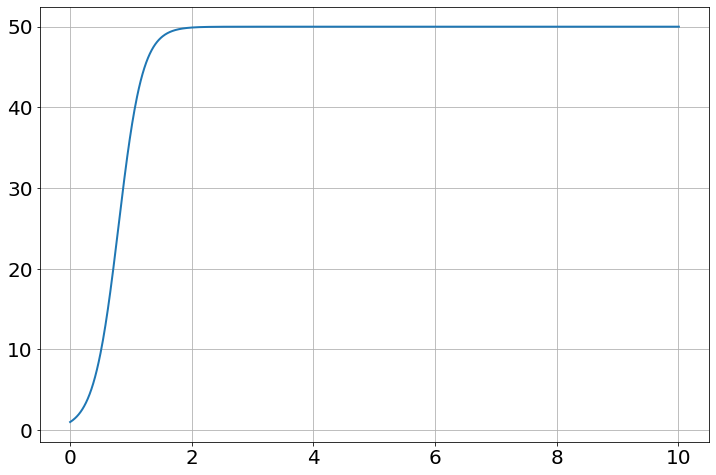

In [ ]:
y=1
x=0
dx=0.01
a=0.1

S=Storage()  # this object will store data
S+=x,y   # adds this to the store, one data point at a time
while x<=10:
    dy=a*y*(50-y)*dx
    y+=dy
    x+=dx
    
    S+=x,y  # adds this to the store, one data point at a time
    
x,y=S.arrays()  # returns an array representation of all those data points
plot(x,y)

In [ ]:
x,y

(array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.990e+00, 1.000e+01,
        1.001e+01]),
 array([ 1.       ,  1.049    ,  1.1003496, ..., 50.       , 50.       ,
        50.       ]))

In [ ]:
#| export
class particle(object):

    def __init__(self,parameters,fitness_function,extra=None):
        self.chi=0.72
        self.w=1.0
        self.c1=2.05
        self.c2=2.05
        self.extra=extra
        
        self.fitness_function=fitness_function
        self.dim=len(parameters)
        self.parameters=parameters
        self.parameter_names=[]
        self.x=[]
        self.v=[]
        for p in parameters:
            self.parameter_names.append(p[0])
            self.x.append(random.rand()*(p[1][1]-p[1][0])+p[1][0])
            self.v.append((2*random.rand()-1)*(p[1][1]-p[1][0]))

        self.x=array(self.x)
        self.v=array(self.v)

        self.best=self.x[:]
        
        if self.extra is None:
            self.best_val=self.fitness_function(self.x)
        else:
            self.best_val=self.fitness_function(self.x,self.extra)
        
    def fitness(self):
        if self.extra is None:
            val=self.fitness_function(self.x)
        else:
            val=self.fitness_function(self.x,self.extra)

        if val<self.best_val:
            self.best_val=val
            self.best=self.x[:]
            
        return val
        
    def update(self,global_best):
    
        r1=random.rand(len(self.x))
        r2=random.rand(len(self.x))
        
        
        self.v=self.chi*(self.w*self.v + 
                    self.c1*r1*(self.best-self.x)+
                    self.c2*r2*(global_best-self.x))
        self.x=self.x+self.v     
        
    def __repr__(self):
        s=""
        for i in range(self.dim):
            s+="(%s: %f) " % (self.parameter_names[i],self.x[i])
        return s
        
class swarm(object):

    def __init__(self,parameters,fitness,
                        number_of_particles=30,extra=None):
        
        self.particles=[particle(parameters,fitness,extra) 
                for i in range(number_of_particles)]

        self.best_val=1e500
        self.best=None
        
    def update(self):
    
        vals=[p.fitness() for p in self.particles]
            
        i=argmin(vals)    
        self.current_best=self.particles[i].x[:]
        self.current_val=vals[i]
        
        if self.current_val<self.best_val:
            self.best_val=self.current_val
            self.best=self.current_best[:]
            
        for p in self.particles:
            p.update(self.best)  
            
                
    def __repr__(self):
        return str(self.particles)
             
                
def pso_fit_sim(varname,xd,yd,sim,parameters,
        n_particles=30,n_iterations=-1,
        progress_interval=100,plot=False):

    extra={'x':xd,'y':yd,'model':sim,'varname':varname,
        'parameters':parameters}
        
    old_plots=[]    
    for c in sim.components:
        old_plots.append(c.plot)
        c.plot=False
        
    s=swarm(parameters,mse_from_sim,n_particles,extra)


    iterations=0
    stop=False
    try:
        while not stop:
            s.update()
            if iterations%progress_interval==0:
                print("iterations", iterations," min fitness: ",s.best_val, " with vals ",s.best)
                
                if plot:
                    pylab.clf()
                    
                    pylab.plot(xd,yd,'o-')        
                    
                    params=s.best
                    y=model(params,xd,sim,varname,parameters)

                    pylab.plot(xd,y,'-',linewidth=2)
                    
                    pylab.draw()
                    #pylab.show()
            iterations+=1
            if n_iterations>0 and iterations>=n_iterations:
                stop=True
    except KeyboardInterrupt:
        pass

    for c,op in zip(sim.components,old_plots):
        c.plot=op

    
    params=s.best
    params_dict={}
    for i,p in enumerate(parameters):
        params_dict[p[0]]=params[i]
    
    return params_dict

      

# Stochastic Sims

In [ ]:
#| export
class Stochastic_Component(object):
    
    def __init__(self,name,initial_value=0,assignment_str=None,
                        min=None,max=None,
                        plot=False,save=None):

        self.name=name
        self.initial_value=initial_value
        
        try:
            self.length=len(initial_value)
            if self.length==1:
                self.initial_value=initial_value[0]
        except TypeError:
            self.length=1
            self.initial_value=initial_value        
            
        self.values=None
        self.min=min
        self.max=max
        self.plot=plot
        self.save=save
        self.assignment_str=assignment_str
        
        self.data={}
    
    def __getitem__(self,s):
        """docstring for __getitem__"""
        return self.values[s]
        
    def __repr__(self):
        if self.assignment_str:
            s="%s: %s\n%s" % (self.name,self.assignment_str,str(self.values))            
        else:
            s="%s\n%s" % (self.name,str(self.values))
        return s

In [ ]:
#| export

class Struct(dict):
    
    def __getattr__(self,name):
        
        try:
            val=self[name]
        except KeyError:
            val=super(Struct,self).__getattribute__(name)
            
        return val
    
    def __setattr__(self,name,val):
        
        self[name]=val



# copied from http://be150.caltech.edu/2018/handouts/l12_stochastic_simulation.html

import numba

def _sample_discrete_nonumba(probs, probs_sum):
    q = np.random.rand() * probs_sum

    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def _gillespie_draw_nonumba(population, args):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Assumes that there is a globally scoped function
    `prop_func` that is Numba'd with nopython=True.
    """
    # Compute propensities
    props = _propensity_function_nonumba(population, args)

    # Sum of propensities
    props_sum = np.sum(props)
    
    if props_sum==0:
        time=1e500
        rxn=0
    else:
    
        # Compute time
        time = np.random.exponential(1 / props_sum)

        # Draw reaction given propensities
        rxn = _sample_discrete_nonumba(props, props_sum)

    return rxn, time

def _gillespie_ssa_nonumba(update, population_0, time_points, args):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
        
    Notes
    -----
    .. Assumes that there is a globally scoped function
       `propensity_func` that is Numba'd with nopython=True.
    """
    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int64)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    extinction_time=-1.0
    previous_t=t
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = _gillespie_draw_nonumba(population, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            previous_t=t
            t += dt

            
        if dt==1e500 and extinction_time<0.0:
            extinction_time=previous_t
        
        # Update the index (Have to be careful about types for Numba)
        i = np.searchsorted((time_points > t).astype(np.int64), 1)

        # Update the population
        for j in np.arange(i_time, min(i, len(time_points))):
            pop_out[j,:] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out,extinction_time




@numba.jit(nopython=True)
def _sample_discrete(probs, probs_sum):
    q = np.random.rand() * probs_sum

    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

@numba.jit(nopython=True)
def _gillespie_draw(population, args):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Assumes that there is a globally scoped function
    `prop_func` that is Numba'd with nopython=True.
    """
    # Compute propensities
    props = _propensity_function(population, args)

    # Sum of propensities
    props_sum = np.sum(props)
    
    if props_sum==0:
        time=1e500
        rxn=0
    else:
    
        # Compute time
        time = np.random.exponential(1 / props_sum)

        # Draw reaction given propensities
        rxn = _sample_discrete(props, props_sum)

    return rxn, time



@numba.jit(nopython=True)
def _gillespie_ssa(update, population_0, time_points, args):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
        
    Notes
    -----
    .. Assumes that there is a globally scoped function
       `propensity_func` that is Numba'd with nopython=True.
    """
    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int64)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    extinction_time=-1.0
    previous_t=t
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = _gillespie_draw(population, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            previous_t=t
            t += dt

            
        if dt==1e500 and extinction_time<0.0:
            extinction_time=previous_t
        
        # Update the index (Have to be careful about types for Numba)
        i = np.searchsorted((time_points > t).astype(np.int64), 1)

        # Update the population
        for j in np.arange(i_time, min(i, len(time_points))):
            pop_out[j,:] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out,extinction_time



class Stochastic_Simulation(object):
    
    def __init__(self):
        self.components=[]
        self.assignments=[]
        self.initial_values={}
        self.current_values={}
        self.ν=None
        self.state_change_strings=[]
        self.rate_equations=[]
        self.quasi=[]
        self._params={}
        self._params_keys=()
        self._params_vals=()
        self.maximum_data_t=-1e500
        self.maximum_t=-1e500
        self.original_params={}

    
    def params(self,**kwargs):
        self._params.update(kwargs)
        self._params_keys=tuple(self._params.keys())
        self._params_vals=tuple([self._params[_] for _ in self._params_keys])
        self.original_params=self._params.copy()
        
    def add_data(self,t,plot=False,**kwargs):
        for key in kwargs:
            found=[c for c in self.components+self.assignments if c.name==key]
            if not found:
                raise ValueError("The variable '%s' is not a variable in the simulation." % key)
                
            c=self.get_component(key)
                
            c.data={'t':t,'plot':plot,'value':kwargs[key]}
            mx=max(t)
            if mx>self.maximum_data_t:
                self.maximum_data_t=mx
        
    def get_component(self,y):
    
        if isinstance(y,int):
            return self.components[y]
        else:
            found=[c for c in self.components+self.assignments if c.name==y]
            if not found:
                raise ValueError("Could not find component %s" % y)
                
            if len(found)>1:
                raise ValueError("Found more than one component %s?" % y)
            
            return found[0]
        
    def interpolate(self,t,cname=None):
        if cname is None:
            cnames=[x.name for x in self.components]
            result={}
            for cname in cnames:
                result[cname]=self.interpolate(t,cname)
            return result
        else:
    
            svals=self[cname]
            st=self['t']
            
            # gives a value error if svals is nan
            try:
                simvals=interp(t,st,svals)
            except ValueError:
                try:
                    simvals=-1e500*ones(len(t))
                except TypeError:  # a float given
                    simvals=-1e500
                
            return simvals
         
    def add(self,component_change_equation,rate_equation=None,plot=False,quasi=None,**kwargs):
        
        
        
        if "=" in component_change_equation:
            name=component_change_equation.split('=')[0].strip()
            self.assignments.append(Stochastic_Component(name=name,assignment_str=component_change_equation))
            return 
        
        component_change_equation=component_change_equation.replace('+',' +')
        component_change_equation=component_change_equation.replace('-',' -')
        
        parts=component_change_equation.split()
        names=[c.name for c in self.components]
        new_names=[]
        for part in parts:
            if not (part.startswith('-') or part.startswith('+')):
                raise SyntaxError("State change strings must start with + or -: %s" % component_change_equation)
            name=part[1:]
            if name not in names+new_names:
                new_names.append(name)
            
        self.state_change_strings.append(component_change_equation)            
        self.rate_equations.append(rate_equation)
        self.initial_values.update(kwargs)
        self.current_values.update(kwargs)
        
        self.components+=[Stochastic_Component(name) for name in new_names]
        
        
        self.quasi.append(quasi)

    def initialize(self):
        # from importlib import reload
        # if '_propensity_function' in globals():
        #     del globals()['_propensity_function']
        #     print("Deleting old _propensity_function")
        #     reload(_gillespie_ssa)
        
        num_components=len(self.components)
        num_reactions=len(self.rate_equations)
        self.ν=np.zeros((num_reactions,num_components),int)
        
        names=[c.name for c in self.components]
        
        for j,(state_change,rate) in enumerate(zip(self.state_change_strings,self.rate_equations)):
            parts=state_change.split()
            for part in parts:
                if not (part.startswith('-') or part.startswith('+')):
                    raise SyntaxError("State change strings must start with + or -: %s" % component_change_equation)
                name=part[1:]
                if part[0]=='-':
                    val=-1
                else:
                    val=+1
                
                i=names.index(name)
                self.ν[j,i]=val
                    

        for name in self.initial_values:
            if not name in names:
                c=self.get_component(name)
                raise ValueError("%s not in components values." % c)
                 
        for name in names:
            if not name in self.initial_values:
                raise ValueError("%s not in initial values." % c)
            
            
        # test to see if all the symbols are defined
        D={}
        for c in self.components:
            D[c.name]=1

        for param in self.original_params:
            D[param]=self.original_params[param]

        for c in self.assignments:
            exec(f"{c.assignment_str}",D)

        for eq in self.rate_equations:
            eval(f"{eq}",D)
                
            
            
        #func_str="@numba.jit(nopython=True)\ndef _propensity_function(population, args):\n"
        func_str="@numba.jit\ndef _propensity_function(population, args):\n"

        func_str+="    "
        
        if len(names)>1:        
            func_str+=",".join(names) + " = population\n"
        else:
            func_str+=names[0] + ", = population\n"
                        
        if self._params_keys:
            func_str+="    "
            if len(self._params_keys)>1:        
                func_str+=",".join(self._params_keys)+ " = args\n"
            else:
                func_str+=self._params_keys[0]+ ", = args\n"
            
        func_str+="    "+"\n"

        for c in self.assignments:
            eq=c.assignment_str
            func_str+="    "+eq+"\n"


        func_str+="    "+"\n"


        func_str+="    "+"val = np.array([\n"
        for a in self.rate_equations:
            func_str+="        "+a+",\n"
        func_str+="    "+"])\n"

        for qi,q in enumerate(self.quasi):
            if not q:
                continue
                
            func_str+="    "+f"if ({q}):\n"
            func_str+="    "+"    "+f"val[{qi}]=0\n"
            func_str+="    "+"    "+f"print(val)\n"
        
            func_str+="    "+f"if ((A==0) or (B==0)):\n"
            func_str+="    "+"    "+f"raise ValueError()\n"
                
        
        func_str+="    "+"return val"
        
        
        self.func_str=func_str
            
        exec (func_str, globals())  
        
        #==============================
        func_str="def _propensity_function_nonumba(population, args):\n"

        func_str+="    "
        
        if len(names)>1:        
            func_str+=",".join(names) + " = population\n"
        else:
            func_str+=names[0] + ", = population\n"
                        
        if self._params_keys:
            func_str+="    "
            if len(self._params_keys)>1:        
                func_str+=",".join(self._params_keys)+ " = args\n"
            else:
                func_str+=self._params_keys[0]+ ", = args\n"
            
        func_str+="    "+"\n"

        for c in self.assignments:
            eq=c.assignment_str
            func_str+="    "+eq+"\n"


        func_str+="    "+"\n"


        func_str+="    "+"val = np.array([\n"
        for a in self.rate_equations:
            func_str+="        "+a+",\n"
        func_str+="    "+"])\n"

        for qi,q in enumerate(self.quasi):
            if not q:
                continue
                
            func_str+="    "+f"if ({q}):\n"
            func_str+="    "+"    "+f"val[{qi}]=0\n"
            func_str+="    "+"    "+f"print(val)\n"
        
            func_str+="    "+f"if ((A==0) or (B==0)):\n"
            func_str+="    "+"    "+f"raise ValueError()\n"
                
        
        func_str+="    "+"return val"
        
        
        self.func_str_nonumba=func_str
            
        exec (func_str, globals())                    
        
   
    def run_fast(self,*args,**kwargs):
        self.run(*args,**kwargs)
        
        
    def run(self,t_min=None,t_max=None,Nsims=1,num_iterations=1001,numba=True,**kwargs):
        
        if t_min is None:
            assert self.maximum_data_t>-1e500,"Did you forget to add data to your model?"
            
            t_min=0
            t_max=self.maximum_data_t+0.1
            
        elif t_max is None:
            t_max=t_min
            t_min=0
        
        from tqdm import tqdm
        
        if self.ν is None:
            self.initialize()

        names=[c.name for c in self.components]
        self.all_storage=[]
        
        disable=Nsims==1
        
        population_0=np.array([self.initial_values[c] for c in names], dtype=int)
        time_points=np.linspace(t_min,t_max,num_iterations)        
        args = np.array(self._params_vals)
        n_simulations = Nsims

        # Initialize output array
        pops = np.empty((n_simulations, len(time_points), len(population_0)), dtype=int)
        extinction_time=np.empty(n_simulations,dtype=np.float64)

        # Run the calculations
        for _i in tqdm(range(n_simulations),disable=disable):
            if numba:
                try:
                    pops[_i,:,:],extinction_time[_i] = _gillespie_ssa(self.ν, 
                                                population_0, time_points, args=args)            
                except ValueError:
                    print(self.ν,population_0, time_points, args)
                    raise
            else:
                try:
                    pops[_i,:,:],extinction_time[_i] = _gillespie_ssa_nonumba(self.ν, 
                                                population_0, time_points, args=args)            
                except ValueError:
                    print(self.ν,population_0, time_points, args)
                    raise
                

        self.t=time_points
        self.extinction_times=extinction_time
        D={}
        for _i,c in enumerate(names):
            v=pops[:,:,_i]
            if v.shape[0]==1:
                v=v.ravel()
                
            setattr(self, c,v)
            self.get_component(c).values=v

            D[c]=v
        
        for c in self.assignments:
            eq=c.assignment_str
            exec(eq,D)
            name=c.name
            setattr(self, name,D[name])

            
            
    def __getattr__(self, item):
        """Maps values to attributes.
        Only called if there *isn't* an attribute with this name
        """
        try:
            return self.__getitem__(item)
        except KeyError:
            raise AttributeError(item)

    def __getitem__(self,y):
        import unicodedata
        
        try:
            return self.components[y].values
        except (TypeError,IndexError):
            if y=='t':
                return self.t
                
            found=[c for c in self.components+self.assignments if 
                            c.name==y or unicodedata.normalize('NFKC', c.name)==y]
            if found:
                return found[0].values

            if y in self._params:
                return self._params[y]
            else:
                raise IndexError("Unknown Index %s" % str(y))
            
            
        

100%|██████████| 100/100 [00:00<00:00, 981.58it/s]


@numba.jit(nopython=True)
def _propensity_function(population, args):
    S,I,R = population
    β,γ = args
    
    N=S+I+R
    
    return np.array([
        β*S*I/N,
        γ*I,
    ])



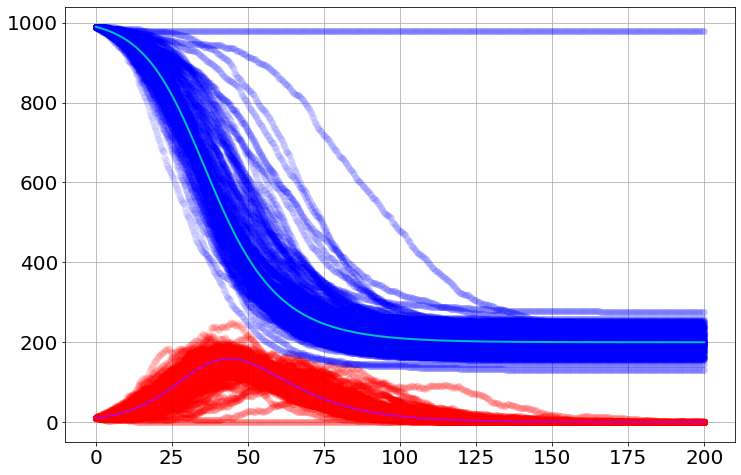

In [ ]:
β=0.2
γ=0.1
So=990
Io=10

dynamic_sim=sim=Simulation()
sim.add("N=S+I+R")
sim.add("S'=-β*S*I/N",So)
sim.add("I'=+β*S*I/N-γ*I",Io)
sim.add("R'=+γ*I",0)
sim.params(β=β,γ=γ)
sim.run(200)


stoch_sim=sim=Stochastic_Simulation()
sim.add("-S+I",'β*S*I/N',S=So,I=Io)
sim.add("-I +R",'γ*I',R=0)
sim.add("N=S+I+R")
sim.params(β=β,γ=γ)
sim.run(200,Nsims=100)

for i in range(100):
    
    plot(sim.t,sim.S[i],'bo',alpha=0.05)
    plot(sim.t,sim.I[i],'ro',alpha=0.05)

plot(dynamic_sim.t,dynamic_sim.S,'c-')
plot(dynamic_sim.t,dynamic_sim.I,'m-')

print(sim.func_str)

In [ ]:
sim.extinction_times

array([173.34641097, 147.2142087 , 173.25806905, 139.46093989,
       141.46950986, 184.82415756, 177.24507978, 162.89244257,
       135.74875203, 142.12308477, 124.1452361 , 103.78449248,
       136.24764907, 141.64503261, 149.02049576, 154.08471155,
       144.36046575, 119.08888338, 126.56068263, 150.96714048,
       185.46651177, 137.75710629, 145.83280943, 161.45092743,
       135.52623017, 158.22300444, 116.4663216 , 142.45833271,
       131.58919096, 132.83514533, 158.67032537, 134.80159232,
       138.67325803, 145.34862087, 175.71694956, 168.1073566 ,
       138.83605961, 131.97878544, 132.29909228, 136.24188252,
       141.72408479, 149.24895424, 140.01290625, 134.00439041,
       128.82634577, 136.28831928, 121.92344439, 157.01860147,
       130.87983952, 190.04334344,  16.78030852, 175.76630482,
       116.42534703, 136.68052456,  -1.        , 136.61710555,
       183.78243168, 159.79643709, 148.65710129, 154.9672915 ,
       160.71863761, 166.15813836, 127.78792513, 139.85

In [ ]:
stoch_sim=sim=Stochastic_Simulation()
sim.add("+X",'X-X**2/N',X=10)
sim.add("-X",'X**2/N')
sim.params(N=10)
sim.run(50,num_iterations=101)

[<matplotlib.lines.Line2D>]

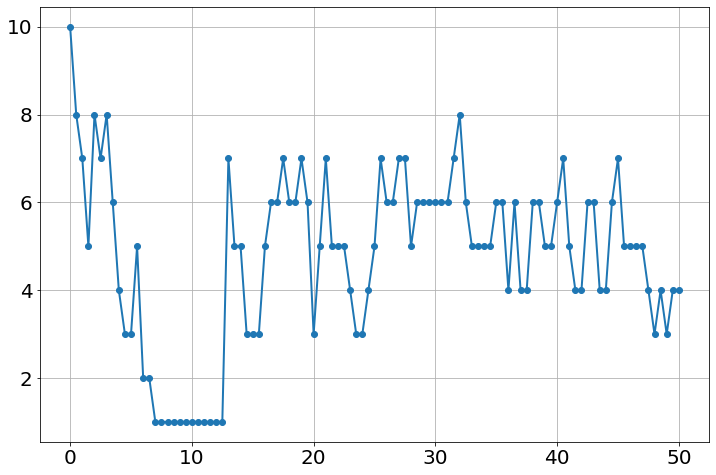

In [ ]:
plot(sim.t,sim.X,'-o')

In [ ]:
sim.extinction_times

array([-1])

# Some Examples

## Logistic

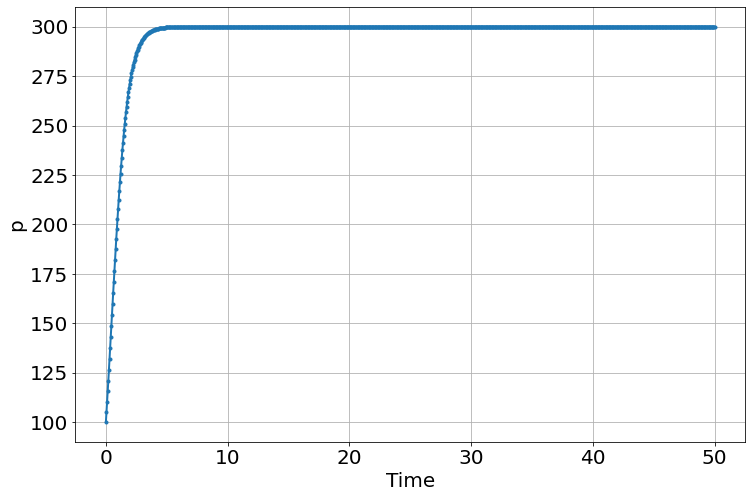

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("p'=a*p*(1-p/K)",100,plot=True)
sim.params(a=1.5,K=300)

sim.run(0,50)

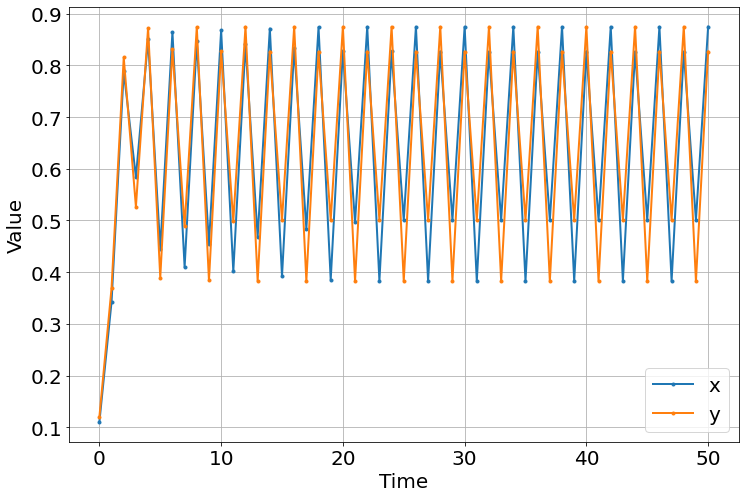

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("x=a*x*(1-x)",0.11,plot=1)
sim.add("y=a*y*(1-y)",0.12,plot=1)
sim.params(a=3.5)

sim.run(0,50,discrete=True)

## Map

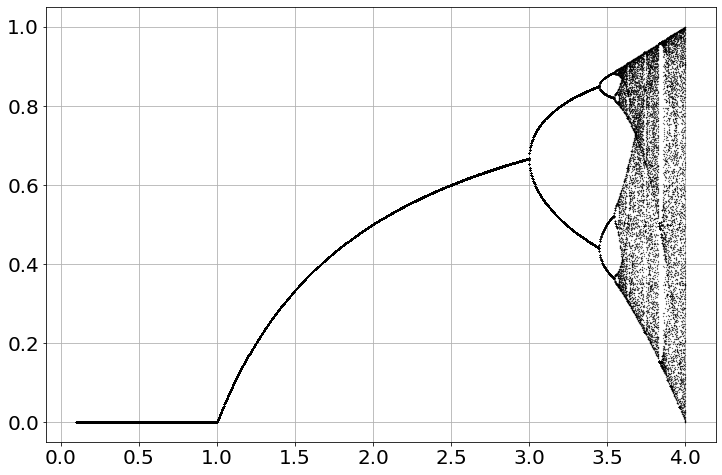

In [ ]:
sim=Simulation('map')
sim.add("x=a*x*(1-x)",0.11)
figure(figsize=(12,8))
for a in linspace(.1,4,1200):
    sim.params(a=a)
    sim.run(0,1000)

    x=sim['x'][-100:]

    plot(a*ones(x.shape),x,'k.',markersize=.5)

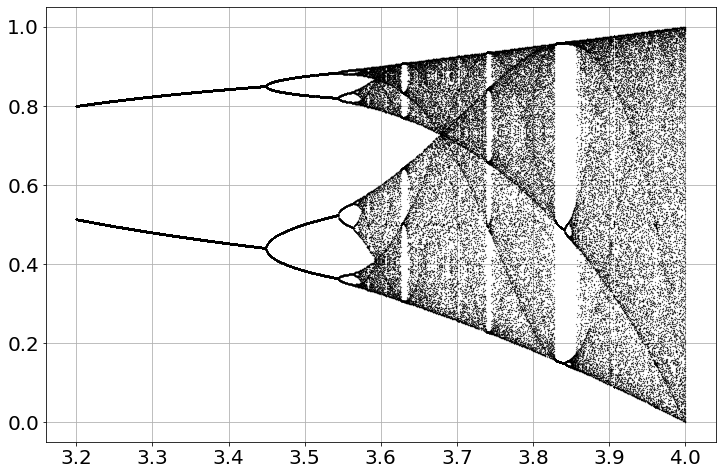

In [ ]:
sim=Simulation('map')
sim.add("x=a*x*(1-x)",0.11)
figure(figsize=(12,8))
for a in linspace(3.2,4,1200):
    sim.params(a=a)
    sim.run(0,1000)

    x=sim['x'][-100:]

    plot(a*ones(x.shape),x,'k.',markersize=.5)

## Repeat

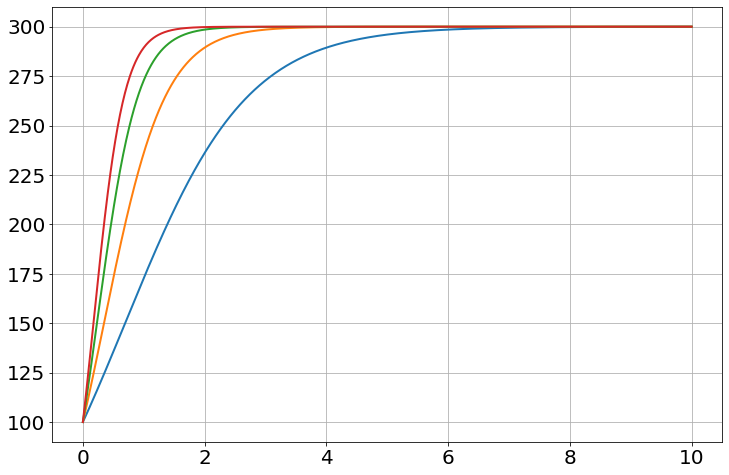

In [ ]:
sim=Simulation()
sim.add("growth_rate=a*(1-p/K)")
sim.add("p'=growth_rate*p",100)
sim.params(a=1.5,K=300)


result=sim.repeat(0,10,a=[1,2,3,4])
t=sim['t']

for res in result:
    p=res['p']
    plot(t,p)

## Higher Order

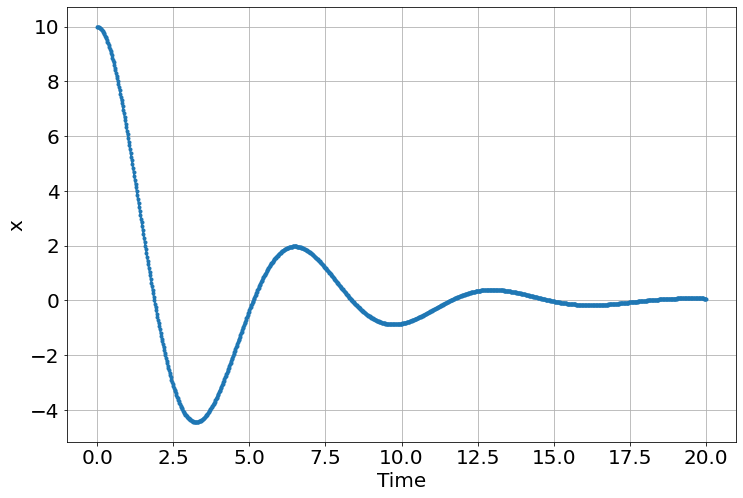

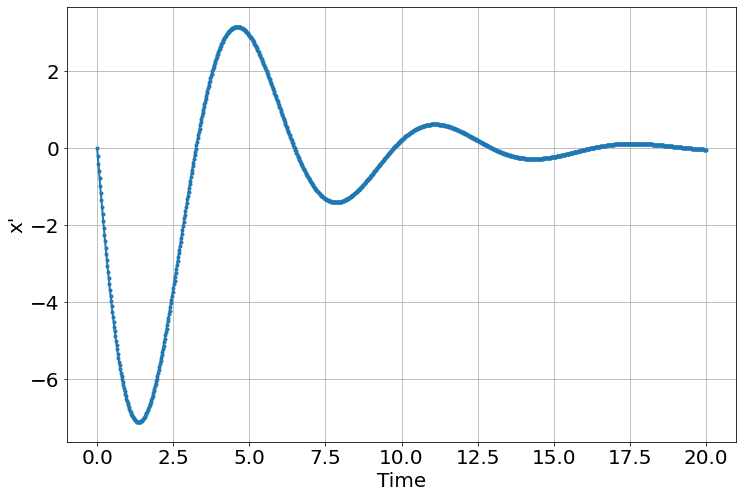

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("x''=-k*x/m -b*x'",[10,0],plot=True)
sim.params(k=1.0,m=1.0,b=0.5)

sim.run(0,20)

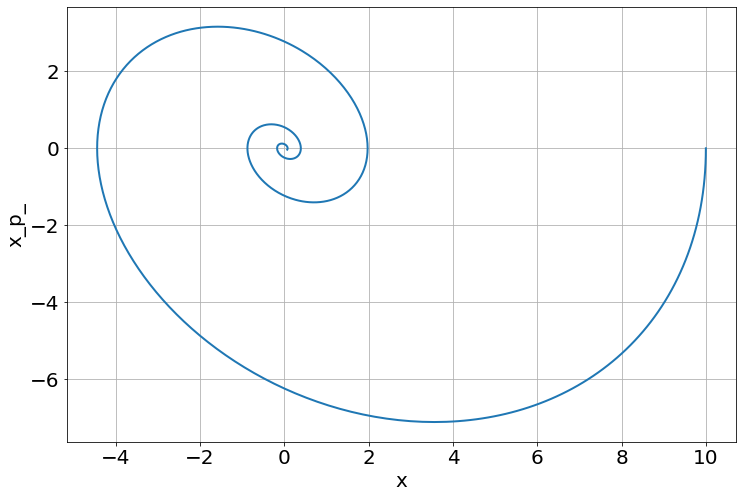

In [ ]:
phase_plot(sim,"x","x_p_")

## Exploring parameters

In [ ]:
#| export
def explore_parameters(sim,figsize=None,**kwargs):

    if figsize is None:
        figsize=sim.figsize


    cnames,cfigs=zip(*[(c.name,c.plot) for c in sim.components+sim.assignments])
    max_int_fig=max(cfigs)

    figs={}
    vars={}

    count=max_int_fig+1
    for name,f in zip(cnames,cfigs):
        if f is True:  # one more fig
            figs[name]=count
            count+=1
        else:
            figs[name]=f

        if not figs[name] in vars:
            vars[figs[name]]=[name]
        else:
            vars[figs[name]].append(name)

    sim.noplots=True
    parameter_names=list(kwargs.keys())

    for pname in parameter_names:
        kwargs[pname]=array(kwargs[pname]).ravel()

    number_of_values=len(kwargs[parameter_names[0]])

    for i in range(number_of_values):

        updated_params={}
        labels=[]
        for pname in parameter_names:
            updated_params[pname]=kwargs[pname][i]
            labels.append("%s:%g" % (pname,updated_params[pname]))

        sim.params(**updated_params)
        sim.run(sim.maximum_t)

        for name in cnames:
            if not figs[name]:
                continue

            t,v=sim.t,sim[name]
            figure(figs[name],figsize=figsize)
            plot(t,v,label=name+":"+",".join(labels))

            xlabel('time')


    for name in cnames:
        if not figs[name]:
            continue
        figure(figs[name])    

        if len(vars[figs[name]])==1:
            ylabel(name)
        else:
            ylabel(",".join(vars[figs[name]]))


        legend()



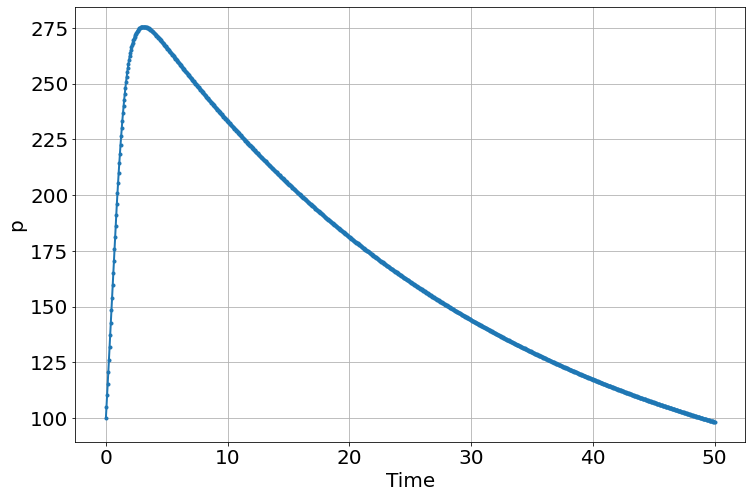

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("p'=a*p*(1-p/K)",100,plot=True)
sim.add("K'=(50-K)/Kt",300,plot=False)
sim.params(a=1.5,Kt=30)

sim.run(0,50)

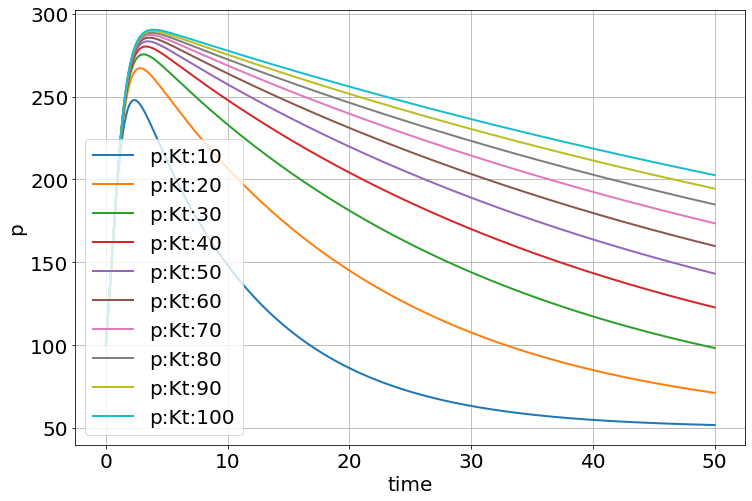

In [ ]:
explore_parameters(sim,Kt=linspace(10,100,10))

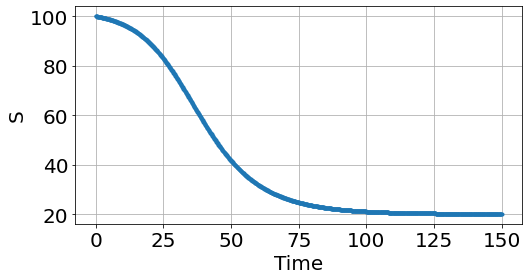

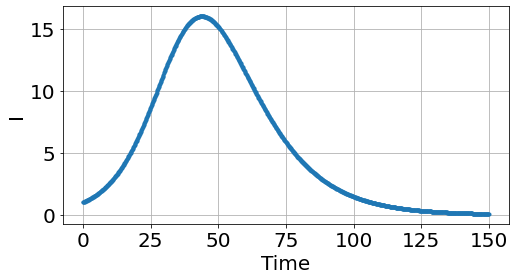

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.figsize=(8,4)
sim.add("S'=-β*S*I/N",100,plot=1)
sim.add("I'=+β*S*I/N - γ*I",1,plot=2)
sim.add("R'=+γ*I",0,plot=0)
sim.add("N=S+I+R",plot=0)
sim.params(β=0.2,γ=0.1)
sim.run(150)

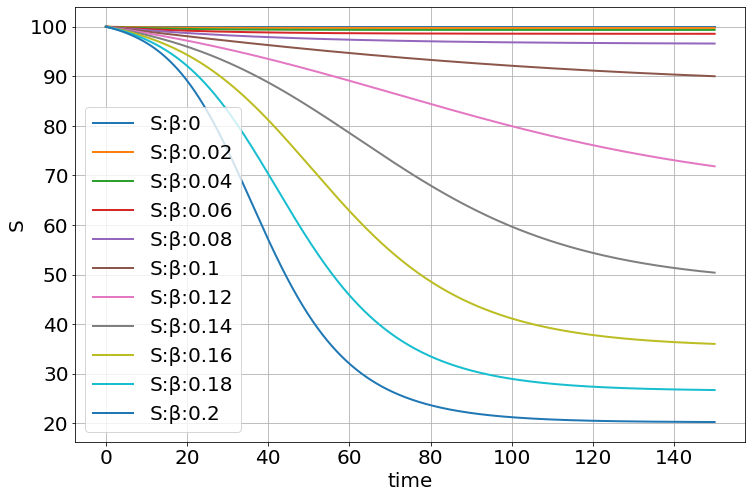

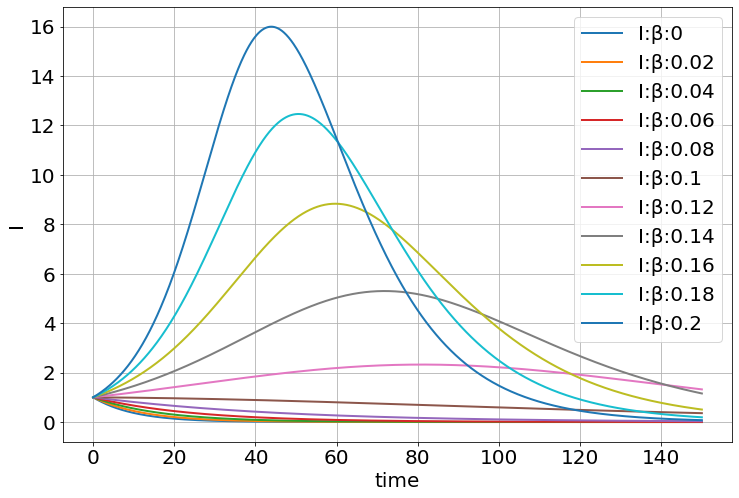

In [ ]:
explore_parameters(sim,figsize=(12,8),β=linspace(0,0.2,11))

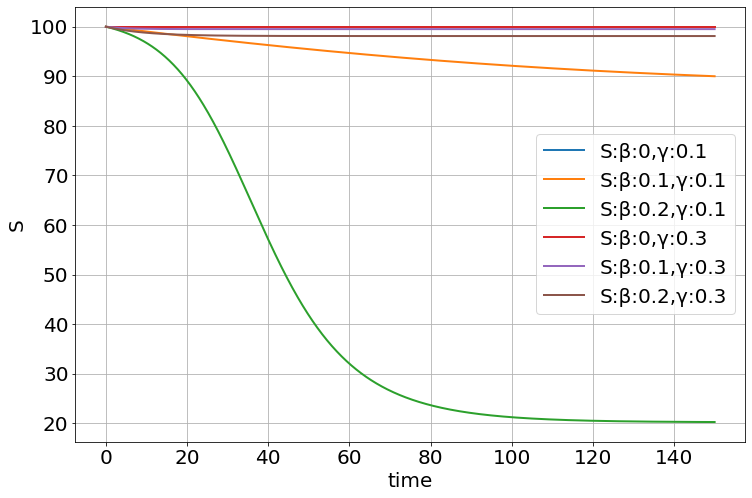

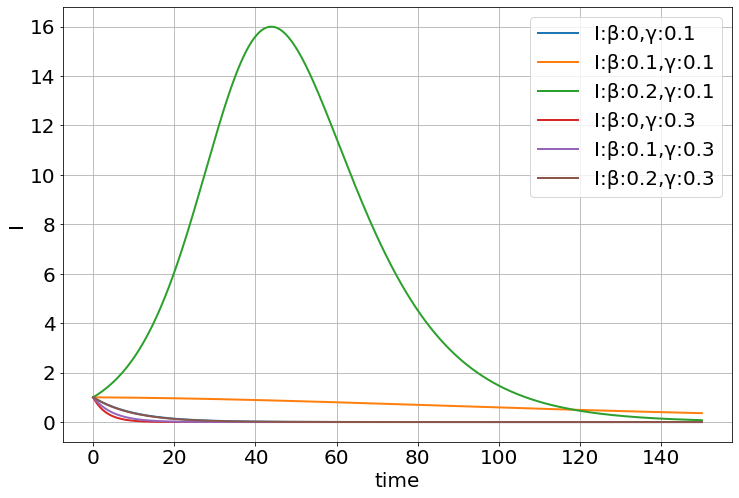

In [ ]:
explore_parameters(sim,figsize=(12,8),β=[0,.1,.2,0,.1,.2],γ=[.1,.1,.1,.3,.3,.3])

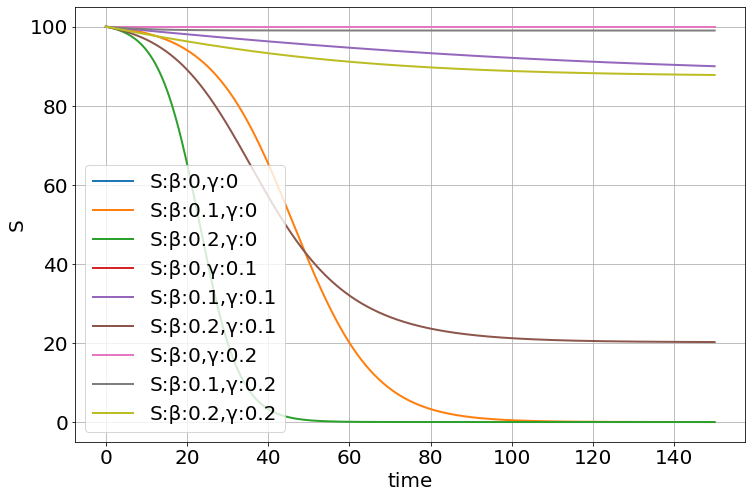

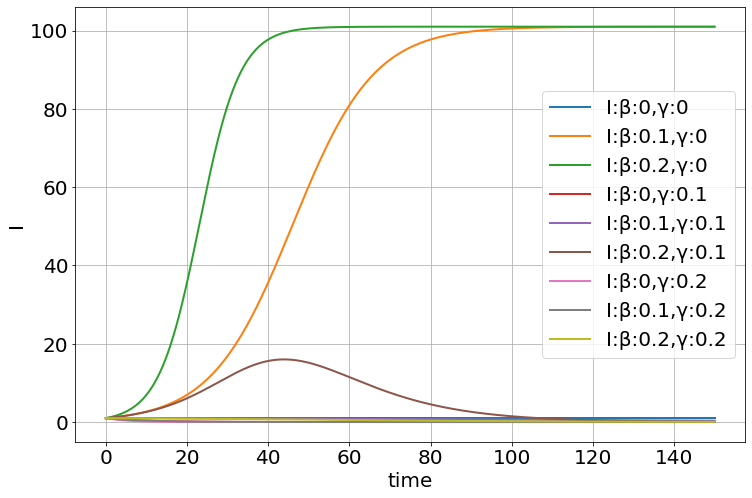

In [ ]:
β,γ=meshgrid([0,.1,.2],[0,.1,.2])
explore_parameters(sim,figsize=(12,8),β=β,γ=γ)

## Functions of time

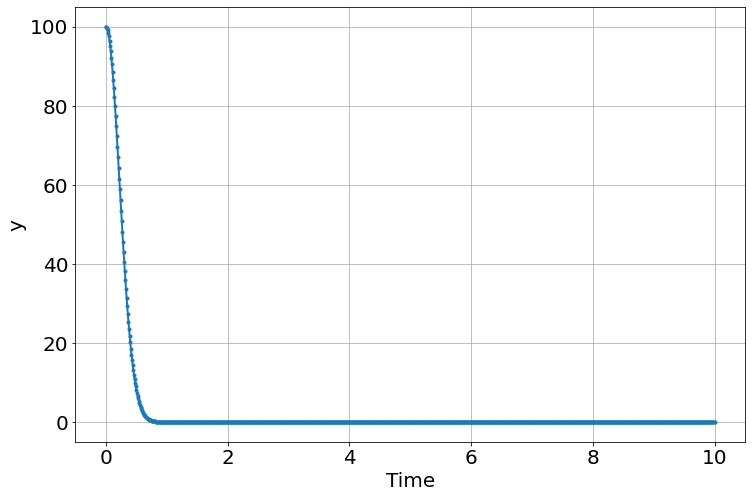

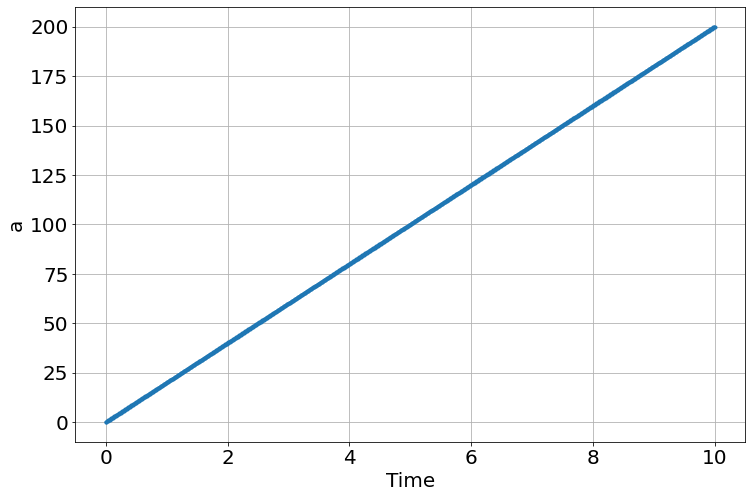

<Figure size 864x576 with 0 Axes>

In [ ]:
def a_vs_time(t):
    return 20*t
    
sim=Simulation()
sim.add("a=a_vs_time(t)",plot=1)
sim.add("y'=-a*y",100,plot=2)
sim.functions(a_vs_time)

sim.run(10)

## Stochastic Simulation Examples

In [ ]:
β=0.2
γ=0.1
So=990
Io=10

dynamic_sim=sim=Simulation()
sim.add("N=S+I+R")
sim.add("S'=-β*S*I/N",So)
sim.add("I'=+β*S*I/N-γ*I",Io)
sim.add("R'=+γ*I",0)
sim.params(β=β,γ=γ)
sim.run(200)


stoch_sim=sim=Stochastic_Simulation()
sim.add("-S+I",'β*S*I/N',S=So,I=Io)
sim.add("-I +R",'γ*I',R=0)
sim.add("N=S+I+R")
sim.params(β=β,γ=γ)
sim.run(200)

100%|██████████| 100/100 [00:00<00:00, 1006.25it/s]


[<matplotlib.lines.Line2D>]

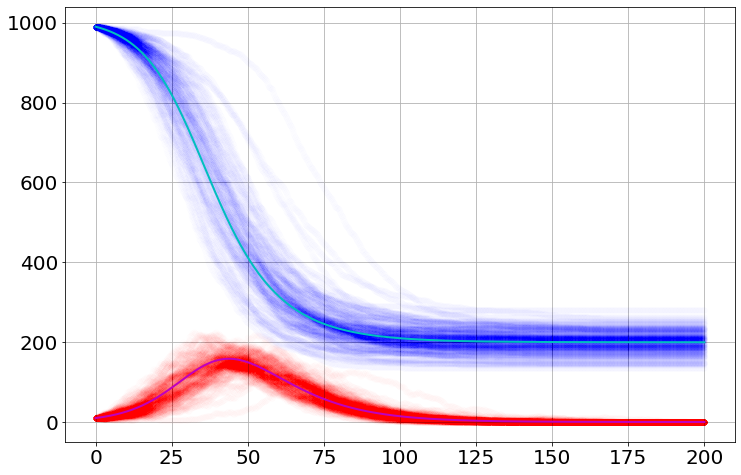

In [ ]:
sim.run(200,Nsims=100)

for i in range(100):
    
    plot(sim.t,sim.S[i],'bo',alpha=0.005)
    plot(sim.t,sim.I[i],'ro',alpha=0.005)

plot(dynamic_sim.t,dynamic_sim.S,'c-')
plot(dynamic_sim.t,dynamic_sim.I,'m-')